# Soil parameters estimation

**Thoughts**

mean values per each band per patch?

pred from mean or mean of preds?

test svm?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from torch.utils.data import DataLoader
from xgboost import XGBRegressor

from src.consts import MAX_PATH
from src.data.dataset import HyperviewDataset
from src.models.modeller import Modeller

## Read model and dataset

In [2]:
IMG_SIZE = 100
CHANNELS = 150
K = 5
NUM_PARAMS = 3
MAX_VAL = 6000
BATCH_SIZE = 16

MODEL_PATH = "output/modeller_var=GaussianRenderer_bias=Mean_k=5_masked.pth"

In [3]:
dir = "data/hyperview/train_data/train_data"
gt_path = "data/hyperview/train_data/train_gt.csv"

In [4]:
model = Modeller(IMG_SIZE, CHANNELS, K, NUM_PARAMS)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [5]:
with open(MAX_PATH, "rb") as f:
    maxx = np.load(f)
maxx[maxx > MAX_VAL] = MAX_VAL

In [6]:
dataset = HyperviewDataset(dir, IMG_SIZE, MAX_VAL, 0, maxx, mask=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [7]:
def prepare_datasets(dataloader: DataLoader) -> list[np.ndarray]:
    imgs = []
    preds = []
    for data in dataloader:
        pred = model(data)
        pred = pred.detach().numpy()
        crop_mask = data[0, 0] == 0
        masked_data = np.where(crop_mask == 1, data, np.nan)
        masked_pred = np.where(crop_mask == 1, pred, np.nan)
        data_mean = np.nanmean(masked_data, axis=(2, 3))
        pred_mean = np.nanmean(masked_pred, axis=(3, 4))
        imgs.append(data_mean)
        preds.append(pred_mean)
    return imgs, preds

Features - mean per patch

In [8]:
imgs, preds = prepare_datasets(dataloader)

In [9]:
imgs = np.array(imgs)
preds = np.array(preds)

In [10]:
img_means = imgs.reshape(imgs.shape[0] * BATCH_SIZE, CHANNELS)
pred_means = preds.reshape(preds.shape[0] * BATCH_SIZE, K * NUM_PARAMS)

In [11]:
gt = pd.read_csv(gt_path)
gt.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [12]:
gt = gt[:img_means.shape[0]]
gt = gt.drop(["sample_index"], axis=1)

In [13]:
x_pred = pred_means
x_img = img_means
y = gt

## Predictions using XGBoost

In [15]:
def predict_params(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=1e-3))
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    mse = mean_squared_error(y_test, preds, multioutput="raw_values")
    return mse

In [16]:
def samples_number_experiment(x: np.ndarray, y: np.ndarray, sample_nums: list[int]) -> list[np.ndarray]:
    x_train_base, x_test, y_train_base, y_test = train_test_split(x, y, test_size=0.2, random_state=21)
    mses = [predict_params(x_train_base, x_test, y_train_base, y_test)]
    for sn in sample_nums:
        x_train, y_train = x_train_base[:sn], y_train_base[:sn]
        mses.append(predict_params(x_train, x_test, y_train, y_test))
    return mses

In [18]:
samples = [1000, 500, 200, 100, 50, 10]

In [19]:
mses_img = np.array(samples_number_experiment(x_img, y, samples))
mses_pred = np.array(samples_number_experiment(x_pred, y, samples))

In [20]:
samples_ticks = [1382, 1000, 500, 200, 100, 50, 10]

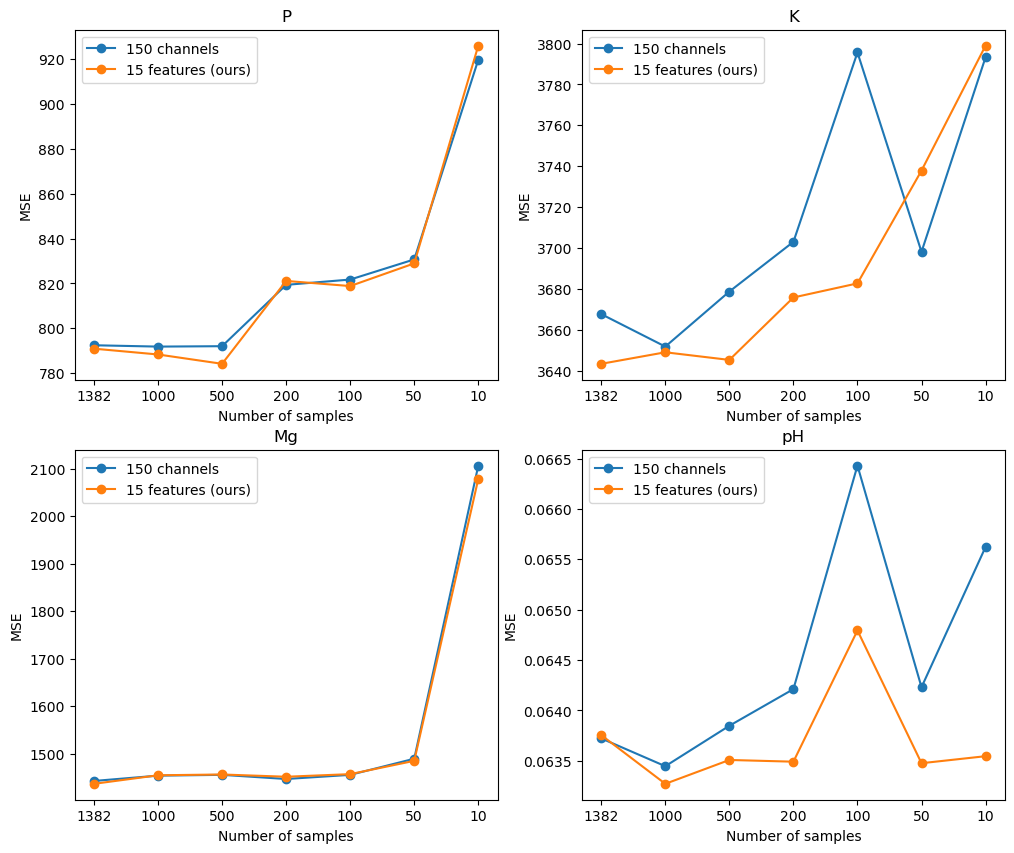

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(fig.axes):
    ax.plot(mses_img[:, i], "-o", label="150 channels")
    ax.plot(mses_pred[:, i], "-o", label="15 features (ours)")
    ax.legend()
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("MSE")
    ax.set_title(gt.columns[i])
    ax.set_xticks(list(range(len(samples_ticks))))
    ax.set_xticklabels(samples_ticks)